In [1]:
#导入模块
from DataSet import myDataSet
from conv3D import CNN3D
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataset_2 import dataset_2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import numpy as np
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
#超参数设计
BATCH_SIZE = 200
num_epochs = 300
LEARNING_RATE=0.02
HEIGHT=56
WIDTH=56

In [ ]:
#导入数据集，数据预处理，加载数据迭代器
dataset = myDataSet(img_dir='..\\project4\\Gauss_S1.00_NL0.30_B0.50\\Gauss_S1.00_NL0.30_B0.50', group_size=10000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
transform=transforms.Compose([
    transforms.ToTensor(),
    # 数据预处理后期添加
])
# 归一化处理，把所有像素值归一化到0-1
X=dataset.X #(10000,4,56,56)
Y=dataset.Y #(10000,1,56,56)

In [ ]:
X = torch.load('..\\project4\\save\\X_dataset_general.pt')
Y = torch.load('..\\project4\\save\\Y_dataset_general.pt')

In [ ]:
min_max_X_values = [] # 保存每个通道的 (min, max) 值
min_max_Y_values=[]
# 对X要分通道进行归一化
for i in range(4):
    x=X[:,i,:,:]
    x_max=x.max()
    x_min=x.min()
    min_max_X_values.append((x_min, x_max)) # 保存 min 和 max 值
    x_new=(x-x_min)/(x_max-x_min)
    X[:,i,:,:]=x_new
y_min=Y.min()
y_max=Y.max()
min_max_Y_values.append((y_min,y_max))
y_new=(Y-y_min)/(y_max-y_min)
Y=y_new

dataset_2=dataset_2(X,Y)
#分割数据集
TRAIN_NUM=int(0.8 * len(dataset_2))
print(TRAIN_NUM)
VAL_NUM=int(0.1 * len(dataset_2))
print(VAL_NUM)
TEST_NUM=len(dataset_2) - TRAIN_NUM - VAL_NUM
print(TEST_NUM)

In [ ]:
torch.manual_seed(48)

train_dataset, val_dataset, test_dataset=random_split(
    dataset_2,[TRAIN_NUM,VAL_NUM,TEST_NUM]
)
#加载数据迭代器（训练，验证，测试）
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # 验证集不需打乱
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # 测试集不需打乱

In [ ]:
# 获取一个样本并打印其张量值，检验归一化是否正确
sample_idx = 0 # 获取第一个样本
X_sample, Y_sample = dataset_2[sample_idx]

# 打印样本的张量值
print("Sample X Tensor:")
print(X_sample)
print("Sample Y Tensor:")
print(Y_sample)

# 检查 X 和 Y 是否在 0 到 1 的范围内
if (X_sample >= 0).all() and (X_sample <= 1).all():
    print("X is within the range [0, 1]")
else:
    print("X is out of bounds!")

if (Y_sample >= 0).all() and (Y_sample <= 1).all():
    print("Y is within the range [0, 1]")
else:
    print("Y is out of bounds!")

In [ ]:
#重新加载模型
import CNNwithAttention 
import importlib
importlib.reload(CNNwithAttention)

In [3]:
''''''''''
创建模型
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN3D().to(device)  # 需要先重新实例化模型结构

In [ ]:
#CNN特供初始化参数
with torch.no_grad():
    # cov3x3 的左半边注意卷积核
    left_half_kernel_3x3 = torch.tensor([
        [[1, 0, 0], [1, 1, 0], [1, 0, 0]]  # 忽略右半部分
    ], dtype=torch.float32)
    model.cov3x3.weight[0] = nn.Parameter(left_half_kernel_3x3.expand(4, 3, 3))  # 应用于第一通道

    # cov3x3 的右半边注意卷积核
    right_half_kernel_3x3 = torch.tensor([
        [[0, 0, 1], [0, 1, 1], [0, 0, 1]]   # 忽略左半部分
    ], dtype=torch.float32)
    model.cov3x3.weight[1] = nn.Parameter(right_half_kernel_3x3.expand(4, -1, -1))  # 应用于第二通道

    # cov5x5 的左半边注意卷积核
    left_half_kernel_5x5 = torch.zeros(5, 5)
    left_half_kernel_5x5[:, :2] = 1  # 左半边设为1
    model.cov5x5.weight[0] = nn.Parameter(left_half_kernel_5x5.expand(4, -1, -1))

    # cov5x5 的右半边注意卷积核
    right_half_kernel_5x5 = torch.zeros(5, 5)
    right_half_kernel_5x5[:, 3:] = 1  # 右半边设为1
    model.cov5x5.weight[1] = nn.Parameter(right_half_kernel_5x5.expand(4, -1, -1))

    # cov7x7 的左半边注意卷积核
    left_half_kernel_7x7 = torch.zeros(7, 7)
    left_half_kernel_7x7[:, :3] = 1  # 左半边设为1
    model.cov7x7.weight[0] = nn.Parameter(left_half_kernel_7x7.expand(4, -1, -1))

    # cov7x7 的右半边注意卷积核
    right_half_kernel_7x7 = torch.zeros(7, 7)
    right_half_kernel_7x7[:, 4:] = 1  # 右半边设为1
    model.cov7x7.weight[1] = nn.Parameter(right_half_kernel_7x7.expand(4, -1, -1))

In [ ]:
#GNN特供就连接关系

def create_grid_edge_index_8_neighborhood(height, width):
    indices = []
    for y in range(height):
        for x in range(width):
            node_index = y * width + x
            # 当前像素的8个邻域
            neighbors = [
                (y-1, x-1), (y-1, x), (y-1, x+1),  # 上左，上，上右
                (y, x-1),              (y, x+1),   # 左，   当前，右
                (y+1, x-1), (y+1, x), (y+1, x+1)   # 下左，下，下右
            ]
            for ny, nx in neighbors:
                if 0 <= ny < height and 0 <= nx < width:
                    neighbor_index = ny * width + nx
                    indices.append([node_index, neighbor_index])

    edge_index = torch.tensor(indices, dtype=torch.long).t().contiguous()
    return edge_index

edge_index = create_grid_edge_index_8_neighborhood(56, 56)


In [4]:
'''''''''
如果有预训练模型，加载预训练模型
'''
# model = torch.load('UNet.pth')
model.load_state_dict(torch.load('..\\project4\\CNN3D_state_dict.pth'))

<All keys matched successfully>

In [5]:
'''''''''
训练模块1
'''
criterion = nn.MSELoss()

In [ ]:
'''''''''
训练模块2
'''
#创立优化器和学习率调整器

optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [ ]:
'''''''''
训练模块3
'''

# 训练模型
train_loss=[]
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    for batch_X, batch_Y in train_loader:
        # print(batch_X.shape)
        # print(batch_Y.shape)
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)  
        optimizer.zero_grad()
        # outputs=model(batch_X,edge_index.to(device))
        outputs=model(batch_X)
        loss=criterion(outputs,batch_Y)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # 在每个 epoch 完成后计算并记录平均损失
    average_loss = running_loss/ len(train_loader) # 计算平均损失
    scheduler.step(average_loss)
    print("第%d个epoch的学习率:%f" % (epoch+1, optimizer.param_groups[0]['lr']))
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss }') # 输出平均损失
    train_loss.append(average_loss)

    
    #验证集
    model.eval()
    with torch.no_grad():
        val_loss=0
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)  
            # outputs=model(X_val,edge_index.to(device))
            outputs=model(X_val)
            val_loss+=criterion(outputs,Y_val).item()
        val_loss/=len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}],Valid Loss: {val_loss}') # 输出平均损失

print('Training finished')

In [ ]:
plt.plot(train_loss, label='train loss', color='blue', linestyle='-')

In [ ]:
#保存模型
torch.save(model.state_dict(), 'CNNwithAttention.pth')

In [ ]:
#在测试集/验证集/训练集上预测并画图
num_cases_to_plot=5
test_samples=list(test_loader)[:num_cases_to_plot]
model.eval()
predicted_images=[]
true_images=[]
print(len(test_samples))

with torch.no_grad():
    for X_test, Y_test in test_samples:
        # outputs=model(X_test.to(device),edge_index.to(device))
        outputs=model(X_test.to(device))
        predicted_images.append(outputs.cpu().detach().numpy())
        true_images.append(Y_test.cpu().detach().numpy())
predicted_images = np.concatenate(predicted_images, axis=0)
true_images = np.concatenate(true_images, axis=0)

IMAGE_NAME = 'Gauss_S1.00_NL0.30_B0.50'
error_list = []
pre_list = np.empty([])
true_list = np.empty([])
# Plotting the results
fig, axes = plt.subplots(num_cases_to_plot, 2, figsize=(10, 4 * num_cases_to_plot))
for i in range(num_cases_to_plot):
    # 假设只有单一通道要显示，可以通过 denormalized_predicted_images 和 denormalized_true_images 访问真实与预测结果
    #以下记得修改
    pred_img = predicted_images[i].reshape(HEIGHT, WIDTH) # 假设输出是单通道形式
    true_img = true_images[i, 0].reshape(HEIGHT, WIDTH) # 假设通道在第一维度
    # 绘制真实图像
    axes[i, 0].imshow(true_img) # 使用灰度图显示
    axes[i, 0].set_title(f'True Image {i+1}')
    axes[i, 0].axis('off')

    # 绘制预测图像
    axes[i, 1].imshow(pred_img) # 使用灰度图显示
    axes[i, 1].set_title(f'Predicted Image {i+1}')
    axes[i, 1].axis('off')
    error_list.append(pred_img-true_img)
    pre_list = np.append(pre_list,pred_img)
    true_list = np.append(true_list,true_img)
plt.show()

In [ ]:
#计算测试集上的损失以及误差
errors = np.array([])
Y_test_1 = np.array([])
model.eval()
with torch.no_grad():
    test_loss=0
    for X_test, Y_test in test_loader:
        outputs=model(X_test.to(device))
        test_loss+=criterion(outputs, Y_test.to(device)).item()
        errors = np.append(errors,outputs.cpu().detach().numpy().reshape(-1)-Y_test.cpu().detach().numpy().reshape(-1))
        Y_test_1 = np.append(Y_test_1,Y_test.cpu().detach().numpy().reshape(-1))
    test_loss/=len(test_loader)
print(f'test loss: {test_loss}')
print(len(errors))

In [ ]:
#定义画图类
class Plotter:
    def __init__(self):
        pass
    def plot_histogram(self, data_list, num_bins=10, color='blue', title='Histogram',xlabel='Values',ylabel='Frequency',net = 'None',
                    text = 'None',need_log_scale=False,range=[-1,-1],image_info = 'None',data_points='0',alpha = 1,label = 'None'):
        # 计算范围
        data_min, data_max = np.min(data_list), np.max(data_list)
        if range == [-1,-1]:
            data_range = (data_min, data_max)
        else :
            data_range = range
        hist, bin_edges=np.histogram(data_list,bins=num_bins,range=data_range)
        max_bin_index = np.argmax(hist)
        max_bin_range = (bin_edges[max_bin_index], bin_edges[max_bin_index + 1])
        max_bin_freq = hist[max_bin_index] # 该 bin 的频率
        print(f"频率最高的 bin 的范围是: {max_bin_range}，频率为: {max_bin_freq}")
        plt.hist(data_list,bins=num_bins,range=data_range,histtype='stepfilled',align='mid',
                orientation='vertical',color=color, alpha = alpha, label = label)
        if need_log_scale:
            plt.yscale('log')
        plt.title(title,fontsize=13)
        plt.xlabel(xlabel,fontsize=12)
        plt.tick_params(labelsize=12)
        plt.ylabel(ylabel,fontsize=12)
        plt.legend()

In [ ]:
#绘制误差直方图
plotter3 = Plotter()
errors_1 = [error/Y for error,Y in zip(errors,Y_test_1) if Y !=0]
plotter3.plot_histogram(errors_1, num_bins=1000, color='blue',range = [-5,2],title='Performance of UNet',
                        xlabel='Residuals', ylabel='Frequency',net = 'UNet',
				        label = 'Gauss_S1.00_\nNL0.30_B0.50',image_info=IMAGE_NAME,data_points=str(len(errors)))

In [ ]:
#保存误差列表为txt文件
np.savetxt('UNet.txt', errors_1)

In [6]:
from DataSet import myDataSet
#导入jet数据集并预处理，加载数据迭代器
dataset1 = myDataSet(img_dir='..\\project4\\Gauss_S1.00_NL0.30_B0.50_jet\\Gauss_S1.00_NL0.30_B0.50_jet', group_size=1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
transform=transforms.Compose([
    transforms.ToTensor(),
    # 数据预处理后期添加
])
# 归一化处理，把所有像素值归一化到0-1
X=dataset1.X #(1000,4,56,56)
print(X.size())
Y=dataset1.Y #(1000,1,56,56)
print(Y.size())

Using device: cuda
torch.Size([1000, 4, 56, 56])
torch.Size([1000, 1, 56, 56])


In [7]:
torch.save(X, '..\\project4\\save\\X_withjet_dataset_general.pt')
torch.save(Y, '..\\project4\\save\\Y_withjet_dataset_general.pt')

In [6]:
X = torch.load('..\\project4\\save\\X_withjet_dataset_general.pt')
Y = torch.load('..\\project4\\save\\Y_withjet_dataset_general.pt')

In [7]:
min_max_X_values = [] # 保存每个通道的 (min, max) 值
min_max_Y_values=[]
# 对X要分通道进行归一化
for i in range(4):
    x=X[:,i,:,:]
    x_max=x.max()
    x_min=x.min()
    min_max_X_values.append((x_min, x_max)) # 保存 min 和 max 值
    x_new=(x-x_min)/(x_max-x_min)
    X[:,i,:,:]=x_new
y_min=Y.min()
y_max=Y.max()
min_max_Y_values.append((y_min,y_max))
y_new=(Y-y_min)/(y_max-y_min)
Y=y_new
from dataset_2 import dataset_2 #找回被释放的内存
dataset1=dataset_2(X,Y)
#分割数据集
TEST_NUM=1000
BATCH_SIZE=200
print(TEST_NUM)
test_loader_jet = DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=False)

1000


In [8]:
print(min_max_Y_values[0][1],min_max_Y_values[0][0])
Y_max = min_max_Y_values[0][1].item()
Y_min = min_max_Y_values[0][0].item()

tensor(104.0961) tensor(0.)


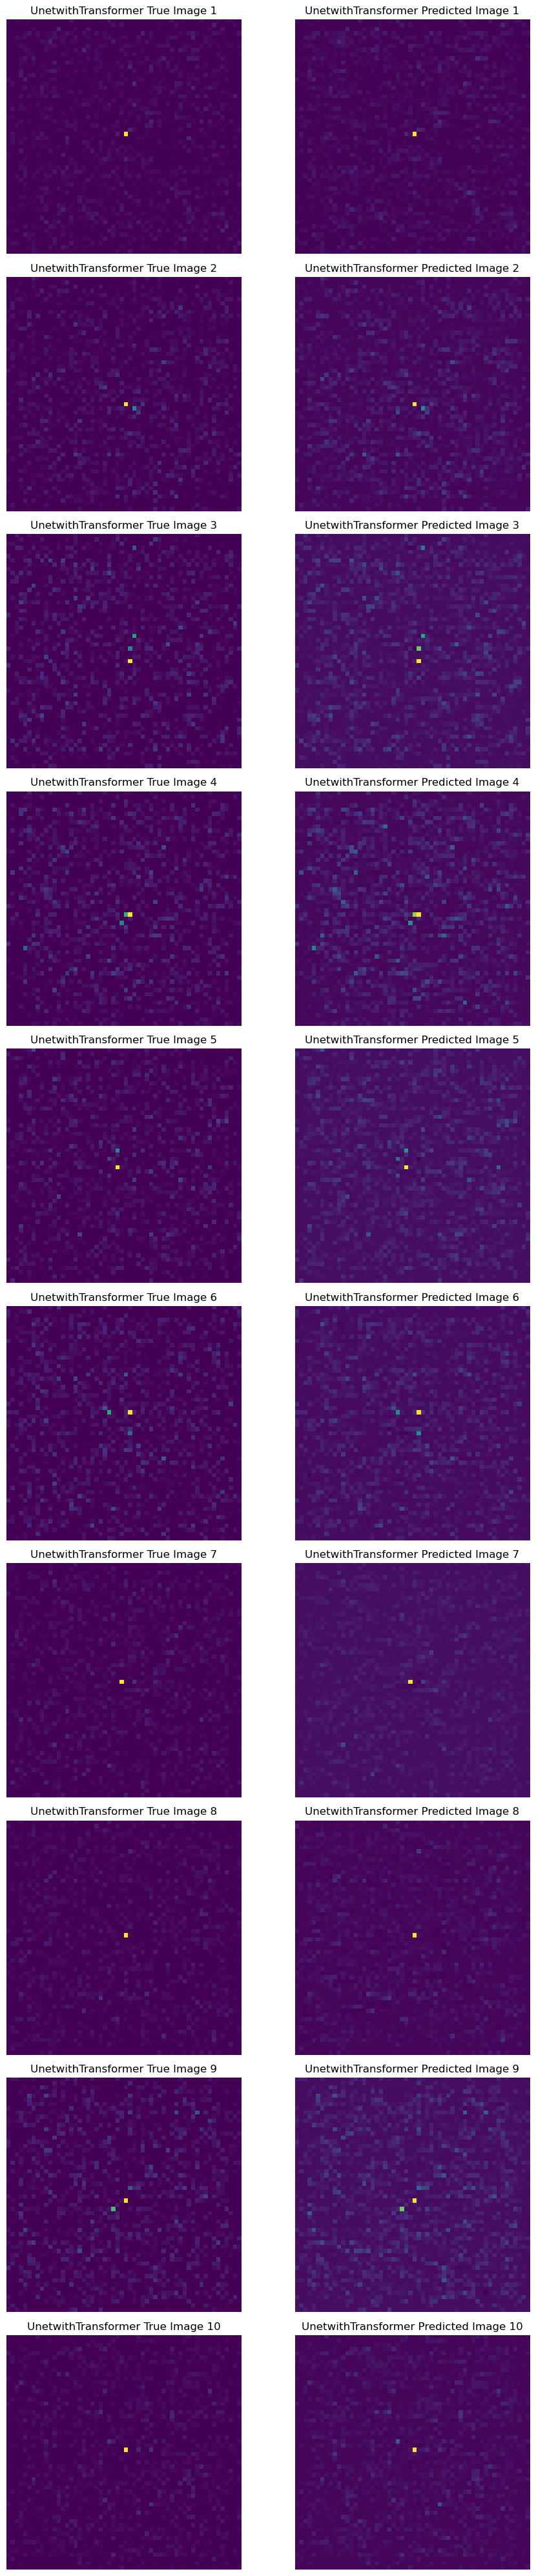

In [12]:
#从数据集中选择五组数据预测并画图
test_samples_jet=test_loader_jet
model.eval()
predicted_images=[]
true_images=[]

with torch.no_grad():
    for X_test, Y_test in test_samples_jet:
        outputs=model(X_test.to(device))
        predicted_images.append(outputs.cpu().detach().numpy())
        true_images.append(Y_test.cpu().detach().numpy())
predicted_images = np.concatenate(predicted_images, axis=0)
true_images = np.concatenate(true_images, axis=0)

IMAGE_NAME = 'Gauss_S1.00_NL0.30_B0.50'
error_list = []
pre_list = np.empty([])
true_list = np.empty([])
# Plotting the results
fig, axes = plt.subplots(10, 2, figsize=(10, 4 * 10))
# predicted_images = test_dataset
for i in range(10):
    # 假设只有单一通道要显示，可以通过 denormalized_predicted_images 和 denormalized_true_images 访问真实与预测结果
    pred_img = predicted_images[i, 0].reshape(HEIGHT, WIDTH) # 假设输出是单通道形式
    true_img = true_images[i, 0].reshape(HEIGHT, WIDTH) # 假设通道在第一维度
    # 绘制真实图像
    axes[i, 0].imshow(true_img) # 使用灰度图显示
    axes[i, 0].set_title(f'UnetwithTransformer True Image {i+1}')
    axes[i, 0].axis('off')

    # 绘制预测图像
    axes[i, 1].imshow(pred_img) # 使用灰度图显示
    axes[i, 1].set_title(f'UnetwithTransformer Predicted Image {i+1}')
    axes[i, 1].axis('off')
    error_list.append(pred_img-true_img)
    pre_list = np.append(pre_list,pred_img)
    true_list = np.append(true_list,true_img)
plt.tight_layout()
plt.show()

In [14]:
import math
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
cnt=0
nums = []
# 创建一个初始长度为10且所有元素为0的一维数组
# torch.set_printoptions(threshold=np.inf)
# np.set_printoptions(threshold=np.inf)
# sys.stdout=open('UTran.txt','w')
n = 0
save_dir = "D:\LECINSUMMER\\final_version\\predict\\"
model.eval()
i = 0
with torch.no_grad():
    for X_test, Y_test in test_loader_jet:
        outputs=model(X_test.to(device))
        for img in outputs:
                if i == 8:
                    img = img.cpu().detach().view(56,56).numpy()*(Y_max - Y_min) + Y_min
                # 保存 img 为 56 行 56 列的 txt 文件
                    np.savetxt(f"{save_dir}/img_{i}.txt", img, fmt='%.6f')
                i+=1

In [9]:
import math
import os
import sys
cnt=0
nums = []
# 创建一个初始长度为10且所有元素为0的一维数组
torch.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=np.inf)
sys.stdout=open('CNN3D.txt','w')
model.eval()
with torch.no_grad():
    for X_test, Y_test in test_loader_jet:
        outputs=model(X_test.to(device))
        for output, truth in zip(outputs,Y_test):#output和turth都是56*56的tensor
            channels,height, width=output.shape
            num=0
            for h in range(height):
                for w in range(width):
                    pixel_value =output[0, h, w]
                    if pixel_value>0:
                        num=num+1
            nums.append(num)
for i in range(len(nums)):
    print(nums[i])
with torch.no_grad():
    for X_test, Y_test in test_loader_jet:
        outputs=model(X_test.to(device))
        outputs = outputs*(min_max_Y_values[0][1]-min_max_Y_values[0][0])+min_max_Y_values[0][0]
        Y_test = Y_test*(min_max_Y_values[0][1]-min_max_Y_values[0][0])+min_max_Y_values[0][0]
        for output, truth in zip(outputs,Y_test):#output和turth都是56*56的tensor
            channels,height, width=output.shape
            for h in range(height):
                for w in range(width):
                    pixel_value =output[0, h, w]
                    if pixel_value>0:
                        pz=h+0.5-28
                        py=(56/2/math.pi)*math.cos((w+0.5)/56*2*math.pi)
                        px=(56/2/math.pi)*math.sin((w+0.5)/56*2*math.pi)
                        pr=math.sqrt(px*px+py*py+pz*pz)
                        px=px/pr
                        py=py/pr
                        pz=pz/pr
                        print(f'{px} {py} {pz} {pixel_value}')

In [10]:
sys.stdout.close()
sys.stdout = sys.__stdout__